# Python surprise で作る らくらく「レコメンドエンジン」（その３） – AutoML（自動機械学習）的レコメンドエンジン構築 –

url: https://www.salesanalytics.co.jp/datascience/datascience182/

    協調フィルタリングやSVDなどの鉄板の「推薦システム（レコメンドエンジン）」であれば、PythonのSurpriseライブラリで簡単に作れます。
    このライブラリは推薦アルゴリズムの学習と予測を簡単に行うことができます。
    前々回、 Surprise でレコメンドエンジンの簡単な作り方について説明しました。

url: https://www.salesanalytics.co.jp/datascience/datascience180/

    推薦アルゴリズムの中には、ハイパーパラメータを持つものがあり、適切なチューニングをした方がよい場合があります。
    ということで前回は、ハイパーパラメータ調整しレコメンドエンジンを構築する方法について説明しました。

url: https://www.salesanalytics.co.jp/datascience/datascience181/

    前回まではSVD (Singular Value Decomposition)でレコメンドエンジンを構築してきましたが、surpriseにはたくさんの推薦アルゴリズムが実装されています。

    どうせなら、最適な推薦アルゴリズムでレコメンドエンジンを構築するのがいいでしょう。

    ただ、1つ1つ構築し検証するのも面倒です。

    そこで、最適な推薦アルゴリズムを自動探索できたら、どんなに素敵でしょうか。

    そのとき、ハイパーパラメータもチューニングしてくれたら、もっと素敵です。

    今回は、Surprise で 最適なレコメンドエンジンを探索し構築する方法について説明します。
    
    こうなってくると、ほぼAutoML（自動機械学習）ですので、実行時間はとってもかかりますので、ご了承ください。

## 今回使う推薦アルゴリズム

今回は、以下の推薦アルゴリズムを使います。

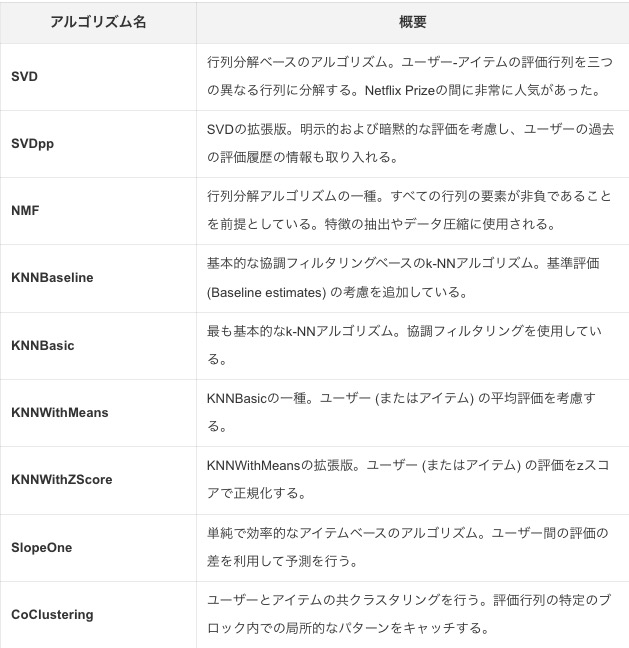

## 推薦システム（レコメンドエンジン）を作る
    流れ
    取り急ぎ、以下の手順で作って行きます。

1. 必要なモジュールの読み込み
2. データセットの読み込み（前回と同じMovieLens）
3. 各アルゴリズムのハイパーパラメータの範囲を定義
4. 最適な推薦アルゴリズムの探索
5. レコメンドの実施

    おまけで、以下の説明もします。
    ・レコメンド結果をCSVファイルとして出力
    ・モデルを外部ファイルとして保存&読み込み

## 必要なモジュールの読み込み
    先ず、必要なモジュールを読み込みます。

    以下、コードです。

In [1]:
# pip install scikit-surprise

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162653 sha256=515a8b1c2a248ee1c8f9c457d4fde95611d46ef2b67bf631a6f51a089e8ab712
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [1]:
import pandas as pd
from surprise import Dataset
from surprise import (SVD, SVDpp, NMF,
                      KNNBaseline, KNNBasic,
                      KNNWithMeans, KNNWithZScore,
                      SlopeOne, CoClustering)
from surprise.model_selection import GridSearchCV
import sys
from io import StringIO
# 標準出力を保存
original_stdout = sys.stdout

    import pandas as pd:
    pandasというデータ分析用のPythonライブラリをpdという名前でインポートします。
    主にデータフレームの操作に使用されます。

    from surprise import Dataset:
    推薦システム用ライブラリsurpriseからDatasetクラスをインポートします。
    Datasetクラスはデータセットのロードに使用されるクラスです。

    from surprise import ...:
    同じくsurpriseライブラリから、複数の推薦アルゴリズムのクラスをインポートします。

    from surprise.model_selection import GridSearchCV:
    GridSearchCVクラスをインポートします。
    このクラスはハイパーパラメータの探索を行い、最適なハイパーパラメータの組み合わせを特定するために使用されます。

    from surprise import dump:
    dumpモジュールをインポートします。
    学習済みのモデルを保存したり、保存されたモデルを読み込んだりするための機能を提供します。

    import sys and from io import StringIO:
    sysモジュールとStringIOクラスをインポートします。
    これらは、標準出力を制御するために使用されます。
    
    original_stdout = sys.stdout:
    現在の標準出力（通常はコンソールへの出力）の設定を変数original_stdoutに保存します。
    後で標準出力の設定を元に戻す際にこの変数を使用することができます。

## データセットの読み込み

次に、MovieLens データセットをロードします。前回利用したものと同じデータセットです。

以下、コードです。

In [2]:
data = Dataset.load_builtin("ml-100k")

    具体的には、3つの変数からなります。
    user：ユーザーの識別子
    item：アイテム（今回は、映画）の識別子
    rating：評価値（今回は、1～5までの5段階評価）

## 各アルゴリズムのハイパーパラメータの範囲を定義
推薦アルゴリズムのハイパーパラメータをチューニングするための、パラメータの探索範囲を定義します。

以下、コードです。

In [3]:
algo_params = {
    'SVD': {
        'n_epochs': [5, 10],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6]
    },
    'SVDpp': {
        'n_epochs': [5, 10],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6]
    },
    'NMF': {
        'n_epochs': [5, 10],
        'n_factors': [10, 15],
        'reg_pu': [0.06, 0.1],
        'reg_qi': [0.06, 0.1]
    },
    'KNNBaseline': {
        'k': [20, 40],
        'sim_options': {
            'name': ['msd', 'cosine'],
            'user_based': [False, True]
        }
    },
    'KNNBasic': {
        'k': [20, 40],
        'sim_options': {
            'name': ['msd', 'cosine'],
            'user_based': [False, True]
        }
    },
    'KNNWithMeans': {
        'k': [20, 40],
        'sim_options': {
            'name': ['msd', 'cosine'],
            'user_based': [False, True]
        }
    },
    'KNNWithZScore': {
        'k': [20, 40],
        'sim_options': {
            'name': ['msd', 'cosine'],
            'user_based': [False, True]
        }
    },
    'SlopeOne': {},
    'CoClustering': {
        'n_cltr_u': [3, 5],
        'n_cltr_i': [3, 5]
    }
}

    以下は、今回チューニングするハイパーパラメータと、その探索範囲の説明です。時間がかかるため、ハイパーパラメータの数を少なくし、探索範囲も小さくしています。

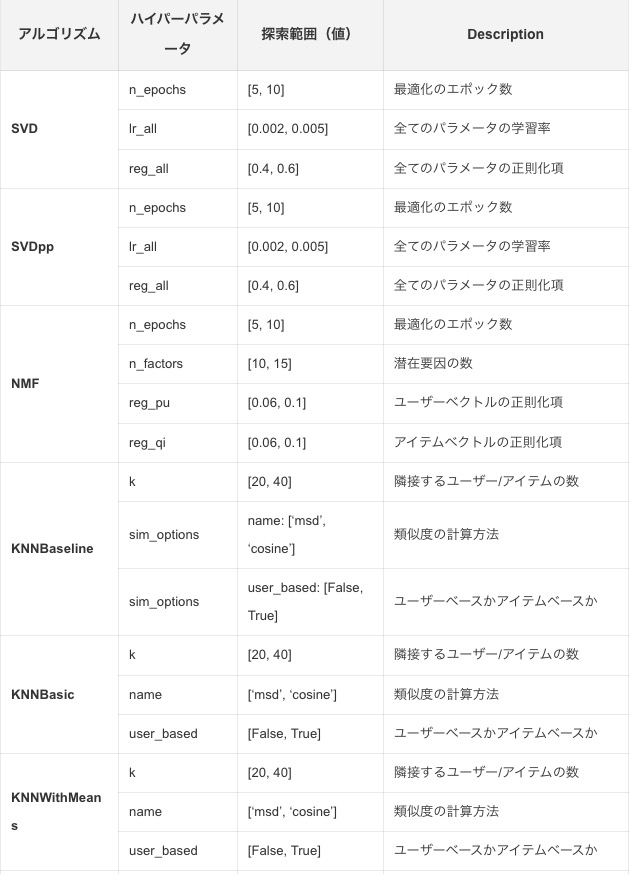

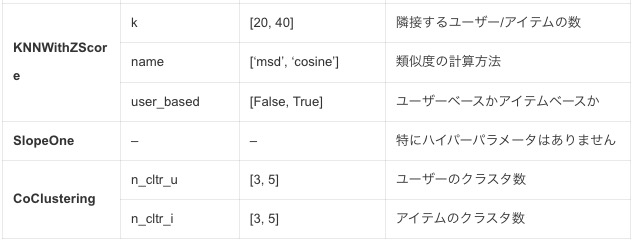

    ハイパーパラメータのある推薦アルゴリズムは、ハイパーパラメータチューニングをグリッドサーチで行います。

## 最適な推薦アルゴリズムの探索

    各アルゴリズムについてGridSearchCV関数（グリッドサーチ×クラスバリデーション）を用いてハイパーパラメータをチューニングし、
    各アルゴリズムの最適なハイパーパラメータの組み合わせを求めます。

    以下、コードです。

In [4]:
best_algos = {}
for algo_name, params in algo_params.items():
    sys.stdout = StringIO() #標準出力を無効にする
    gs = GridSearchCV(eval(algo_name), params, measures=['rmse', 'mae'], cv=10)
    gs.fit(data)
    best_score_rmse = gs.best_score['rmse']
    best_score_mae = gs.best_score['mae']
    best_params = gs.best_params['rmse']
    best_algos[algo_name] = {
        'best_score_rmse': best_score_rmse,
        'best_score_mae': best_score_mae,
        'best_params': best_params
    }
    sys.stdout = original_stdout #標準出力を元に戻す
    # 出力
    print(f"Algorithm: {algo_name}")
    print(f" - Best Parameters: {best_params}")
    print(f" - RMSE: {best_score_rmse}")
    print(f" - MAE: {best_score_mae}")

Algorithm: SVD
 - Best Parameters: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
 - RMSE: 0.9598044552911915
 - MAE: 0.7697846680243224
Algorithm: SVDpp
 - Best Parameters: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
 - RMSE: 0.9597634089424858
 - MAE: 0.7695016942202118
Algorithm: NMF
 - Best Parameters: {'n_epochs': 10, 'n_factors': 15, 'reg_pu': 0.1, 'reg_qi': 0.1}
 - RMSE: 0.9729583363890846
 - MAE: 0.7587430254005249
Algorithm: KNNBaseline
 - Best Parameters: {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}}
 - RMSE: 0.9267718446630819
 - MAE: 0.7285287087981593
Algorithm: KNNBasic
 - Best Parameters: {'k': 40, 'sim_options': {'name': 'msd', 'user_based': False}}
 - RMSE: 0.9664743578387377
 - MAE: 0.7619028456342682
Algorithm: KNNWithMeans
 - Best Parameters: {'k': 40, 'sim_options': {'name': 'msd', 'user_based': False}}
 - RMSE: 0.929887162732838
 - MAE: 0.7293774804503654
Algorithm: KNNWithZScore
 - Best Parameters: {'k': 40, 'sim_options': {'name': 'msd',

    best_algos = {}: 最適なアルゴリズムの情報を保存するための空の辞書を作成。

    for algo_name, params in algo_params.items():: 各アルゴリズムとそのハイパーパラメータに対してループを開始。

    sys.stdout = StringIO(): 一時的に出力を無効化。

    gs = GridSearchCV(...): パラメータ探索を行うためのGridSearchCVを初期化。

    gs.fit(data): パラメータ探索を実行。

    best_score_rmse, best_score_mae, best_params: 最適なスコアとパラメータを取得。

    best_algos[algo_name] = {...}: 最適な結果を辞書に保存。

    sys.stdout = original_stdout: 出力を元に戻す。
    
    print(...): 現在のアルゴリズムの結果を表示。

    出力を一時的に無効化したり元に戻したりしているのは、GridSearchCV関数がグリッドサーチ中に出力する内容を表示させないためです。

    では、最適な推薦アルゴリズムを見てみます。

    以下、コードです。

In [5]:
best_algo_name = min(best_algos, key=lambda k: best_algos[k]['best_score_rmse'])

print(f"Best Algorithm: {best_algo_name}")
print(f" - Best Parameters: {best_algos[best_algo_name]['best_params']}")
print(f" - RMSE: {best_algos[best_algo_name]['best_score_rmse']}")
print(f" - MAE: {best_algos[best_algo_name]['best_score_mae']}")

Best Algorithm: KNNBaseline
 - Best Parameters: {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}}
 - RMSE: 0.9267718446630819
 - MAE: 0.7285287087981593


    best_algo_name = min(...): RMSEが最小のアルゴリズムの名前を取得します。

    best_algos: キーがアルゴリズムの名前で、対応する値はそのアルゴリズムの結果（最適なパラメータ、RMSEスコアなど）の辞書です。

    min(best_algos, key=...): これにより、指定されたキー関数（この場合は上記のラムダ関数）に基づいてbest_algosの中で最小のエントリが返されます。具体的には、最小のRMSEスコアを持つアルゴリズムの名前が返されます。

    lambda k: これは短い無名関数（ラムダ関数）を定義するためのPythonの構文です。この関数はbest_algosの各キー（各アルゴリズムの名前）を引数として受け取り、そのアルゴリズムのRMSEスコアを返します。
    
    key=lambda k: best_algos[k]['best_score_rmse']: best_algos辞書の各エントリの'best_score_rmse'の値に基づいて、min関数が辞書の中で最小の値となるキーを探索する部分です。

    print(f"Best Algorithm: {best_algo_name}"): 最適なアルゴリズムの名前を出力します。

    print(f" - Best Parameters: {best_algos[best_algo_name]['best_params']}"): 最適なアルゴリズムの最適なパラメータを出力します。

    print(f" - RMSE: {best_algos[best_algo_name]['best_score_rmse']}"): 最適なアルゴリズムのRMSEスコアを出力します。
    
    print(f" - MAE: {best_algos[best_algo_name]['best_score_mae']}"): 最適なアルゴリズムのMAEスコアを出力します。

## レコメンドの実施
    全ユーザに対しレコメンドを実施します。

    先ず、先ほど見つけた最適モデルを設定します。

    以下、コードです。

In [6]:
best_algo_instance = eval(best_algo_name)(**best_algos[best_algo_name]['best_params'])

    eval(best_algo_name):
    eval関数は、その引数として渡された文字列をPythonのコードとして評価（実行）します。ここでは、best_algo_nameに格納されているアルゴリズム名の文字列を関数またはクラス名として評価します。
    例えば、best_algo_nameが"SVD"である場合、eval(best_algo_name)はSVDクラス自体を参照します。

    **best_algos[best_algo_name]['best_params']:
    ここでは、**（アンパック）演算子を使用して、辞書のキーと値のペアをキーワード引数として関数に渡しています。
    best_algos[best_algo_name]['best_params']により、最適なパラメータの辞書が取得されます。
    このアンパック操作により、辞書の各キーと値のペアが、アルゴリズムのクラスのコンストラクタにキーワード引数として渡されます。

    eval(best_algo_name)(**best_algos[best_algo_name]['best_params']):
    上記の2つの操作を組み合わせると、最適なアルゴリズムのクラスを特定し、そのクラスのインスタンスを、最適なパラメータを使用して作成します。
    
    結果として、best_algo_instanceには、最適なアルゴリズムの新しいインスタンス（オブジェクト）が格納されます。このインスタンスは、最適なハイパーパラメータを使用して初期化されます。

    次に、レコメンド構築用のデータセットと、レコメンド用のデータセットを作ります。

    以下、コードです。

In [7]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [8]:
display(trainset)
display(testset)

[('196', '302', 3.52986),
 ('196', '377', 3.52986),
 ('196', '51', 3.52986),
 ('196', '346', 3.52986),
 ('196', '474', 3.52986),
 ('196', '265', 3.52986),
 ('196', '465', 3.52986),
 ('196', '451', 3.52986),
 ('196', '86', 3.52986),
 ('196', '1014', 3.52986),
 ('196', '222', 3.52986),
 ('196', '40', 3.52986),
 ('196', '29', 3.52986),
 ('196', '785', 3.52986),
 ('196', '387', 3.52986),
 ('196', '274', 3.52986),
 ('196', '1042', 3.52986),
 ('196', '1184', 3.52986),
 ('196', '392', 3.52986),
 ('196', '486', 3.52986),
 ('196', '144', 3.52986),
 ('196', '118', 3.52986),
 ('196', '1', 3.52986),
 ('196', '546', 3.52986),
 ('196', '95', 3.52986),
 ('196', '768', 3.52986),
 ('196', '277', 3.52986),
 ('196', '234', 3.52986),
 ('196', '246', 3.52986),
 ('196', '98', 3.52986),
 ('196', '193', 3.52986),
 ('196', '88', 3.52986),
 ('196', '194', 3.52986),
 ('196', '1081', 3.52986),
 ('196', '603', 3.52986),
 ('196', '796', 3.52986),
 ('196', '32', 3.52986),
 ('196', '16', 3.52986),
 ('196', '304', 3.5

    data.build_full_trainset(): このメソッドは全てのデータからレコメンド構築用のデータセットを構築します。
    ユーザーとアイテムの評価データ全体を含みます。これを使用することで、全てのデータを使ってモデルを学習できます。

    trainset.build_anti_testset(): このメソッドはユーザーとアイテムの評価がまだされていない組み合わせからなるデータセットを構築します。
    つまり、ユーザーがまだ評価していないアイテムに対する予測を作成するためのデータセットです。
    評価値が不明なアイテムに対して、レコメンドエンジンがどのような評価を予測するために使用されます。

    これらの2つのメソッドを組み合わせることで、全てのデータを用いてレコメンドエンジンを学習し（data.build_full_trainset()）、
    そのレコメンドエンジンを使用してまだ評価されていないアイテムに対する評価を予測する（trainset.build_anti_testset()）ことができます。
    この結果を基にユーザーに対する新たなレコメンデーションを生成することが可能になります。

    レコメンドエンジンを学習します。

    以下、コードです。

In [9]:
best_algo_instance.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


    では、各ユーザーに対して映画のレコメンドを行います。

    各ユーザの評価を予測します。

    以下、コードです。

In [10]:
predictions = best_algo_instance.test(testset)

In [11]:
display(predictions)

[Prediction(uid='196', iid='302', r_ui=3.52986, est=4.086846080347444, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='196', iid='377', r_ui=3.52986, est=2.272678464142385, details={'actual_k': 13, 'was_impossible': False}),
 Prediction(uid='196', iid='51', r_ui=3.52986, est=3.419135593342162, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='196', iid='346', r_ui=3.52986, est=3.3603283105741677, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='196', iid='474', r_ui=3.52986, est=4.360283007085881, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='196', iid='265', r_ui=3.52986, est=3.680179367819325, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='196', iid='465', r_ui=3.52986, est=3.744039036185313, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='196', iid='451', r_ui=3.52986, est=3.4847963115044496, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid

    上位nまで抜き出し、取り扱いやすいように辞書形式で格納します。

    以下、コードです。

In [12]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

In [13]:
top_n

defaultdict(list,
            {'196': [('1500', 5),
              ('814', 5),
              ('1536', 5),
              ('1599', 5),
              ('1653', 4.987596495469051),
              ('1467', 4.984933890928507),
              ('1642', 4.958830487727408),
              ('1449', 4.827283065233454),
              ('1398', 4.821206582761364),
              ('1367', 4.740231260952566)],
             '186': [('1500', 5),
              ('814', 5),
              ('1536', 5),
              ('1599', 5),
              ('1653', 5),
              ('1467', 5),
              ('1642', 4.976317853515399),
              ('1449', 4.8935162738104445),
              ('1398', 4.835772110935197),
              ('1122', 4.770769381345173)],
             '22': [('1500', 5),
              ('814', 5),
              ('1536', 5),
              ('1599', 5),
              ('1467', 4.999881947260812),
              ('1653', 4.923119435549545),
              ('1463', 4.908756658031749),
              ('1449', 4.

    各ユーザーに対する上位n個のアイテムを予測評価値の高い順に抽出し、ユーザーごとにリストとしてtop_nに格納しました。
    このtop_nは、ユーザーIDをキーとし、その値がユーザーにレコメンドされるアイテムのIDと予測評価のリストである辞書です。
    これで完成です。

    ただ、辞書ではなくデータフレームに変換したいな、と思う方もいるかと思います。
    以下で、辞書からデータフレームに変換します。

In [14]:
import pandas as pd

def get_top_n_df(top_n):
    top_n_df = []
    for uid, user_ratings in top_n.items():
        for iid, est in user_ratings:
            top_n_df.append([uid, iid, est])
    return pd.DataFrame(top_n_df, columns=['User', 'Item', 'Estimate'])

top_n_df = get_top_n_df(top_n)

display(top_n_df) #確認

,User,Item,Estimate
0,196,1500,5.000000
1,196,814,5.000000
2,196,1536,5.000000
3,196,1599,5.000000
4,196,1653,4.987596
...,...,...,...
9425,941,1398,5.000000
9426,941,1554,5.000000
9427,941,1599,5.000000
9428,941,1642,5.000000


    ちなみに、特定のユーザとアイテム（映画）を指定し、評価の予測するときには、以下のようにします。

In [15]:
uid = str(597)   # ユーザ
iid = str(1152)  # アイテム（映画）

pred = best_algo_instance.predict(uid, iid, verbose=True)

user: 597        item: 1152       r_ui = None   est = 3.74   {'actual_k': 28, 'was_impossible': False}


    user: 597 : ユーザーIDが597
    item: 1152 : アイテムIDが1152
    r_ui = None : 実際の評価値（ユーザーがアイテムに付けた評価）です。引数で設定していないのでNone
    est = 3.60 : 推定値（予測された評価値）。つまり、アルゴリズムはユーザー597がアイテム1152に対して3.60の評価をすると予測
    {'was_impossible': False} : 予測が不可能だったかどうかを示すフラグ。ここではFalseなので、予測が可能だった

## レコメンド結果をCSVファイルとして出力
    レコメンド結果をcsvファイルなどに保存したいこともあります。

    以下、コードです。

In [16]:
top_n_df.to_csv("recommendations.csv", index=False)

## モデルを外部ファイルとして保存&読み込み
    構築したレコメンドエンジンを外部保存したり、後で読み込んで使いたいこともあります。

    先ず、外部ファイルとして保存します。

    以下、コードです。

In [17]:
from surprise import dump

save_path = f"{best_algo_name}_model.pkl"
dump.dump(save_path, algo=best_algo_instance)

    次に、外部保存したレコメンドエンジンを読み込みます。

    以下、コードです。

In [18]:
from surprise import dump
save_path = "KNNBaseline_model.pkl"
_, loaded_algo = dump.load(save_path)

## まとめ

    今回は、Surprise で 最適なレコメンドエンジンを探索し構築する方法について説明しました。
    
    結構、時間がかかります。

    さらに、構築したレコメンドエンジンを外部保存する方法も説明しました。

    これで、時間をかけて構築したれレコメンドエンジンをいつでも読み込んで使えます。

    次回は、新たなユーザが発生し、そのユーザに対しレコメンドする必要があるケースについてお話しします。